# Method 9 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

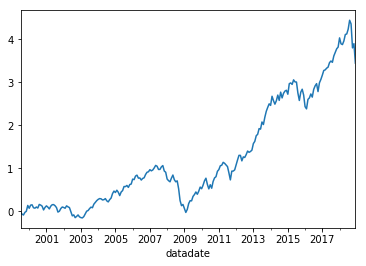

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.137287
2000-12-31   -0.040465
2001-12-31    0.009117
2002-12-31   -0.207907
2003-12-31    0.431918
2004-12-31    0.178119
2005-12-31    0.111039
2006-12-31    0.174521
2007-12-31   -0.005979
2008-12-31   -0.391846
2009-12-31    0.347923
2010-12-31    0.234020
2011-12-31    0.017234
2012-12-31    0.233740
2013-12-31    0.443985
2014-12-31    0.090067
2015-12-31   -0.029226
2016-12-31    0.098375
2017-12-31    0.184634
2018-12-31   -0.077537
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     711.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.74e-128
Time:                        21:01:15   Log-Likelihood:                 693.57
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1360.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.211      0.028       0.000       0.004
mktrf          0.9741      0.024     41.370      0.000       0.928       1.020
me             0.2956      0.027     10.792      0.000       0.242       0.350
ia             0.0745      0.042      1.789      0.075      -0.008       0.156
roe            0.0974      0.036      2.734      0.007       0.027       0.168
==============================================================================
Omnibus:                       24.043   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.192
Skew:                           0.160   Prob(JB):                     1.06e-22
Kurtosis:                       6.206   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     828.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.75e-135
Time:                        21:01:15   Log-Likelihood:                 693.57
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1360.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.598      0.009       0.000       0.003
mktrf          0.9741      0.028     34.299      0.000       0.918       1.030
me             0.2956      0.048      6.169      0.000       0.202       0.389
ia             0.0745      0.087      0.860      0.390      -0.095       0.244
roe            0.0974      0.036      2.698      0.007       0.027       0.168
==============================================================================
Omnibus:                       24.043   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.192
Skew:                           0.160   Prob(JB):                     1.06e-22
Kurtosis:                       6.206   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1108.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.56e-148
Time:                        21:01:15   Log-Likelihood:                 693.57
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1360.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.466      0.014       0.000       0.003
mktrf          0.9741      0.026     38.116      0.000       0.924       1.024
me             0.2956      0.043      6.930      0.000       0.212       0.379
ia             0.0745      0.093      0.805      0.421      -0.107       0.256
roe            0.0974      0.036      2.728      0.006       0.027       0.167
==============================================================================
Omnibus:                       24.043   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.192
Skew:                           0.160   Prob(JB):                     1.06e-22
Kurtosis:                       6.206   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     551.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.91e-125
Time:                        21:01:15   Log-Likelihood:                 690.61
No. Observations:                 234   AIC:                            -1369.
Df Residuals:                     228   BIC:                            -1348.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.094      0.037       0.000       0.004
mktrf          0.9648      0.024     40.291      0.000       0.918       1.012
smb            0.3388      0.032     10.724      0.000       0.277       0.401
hml            0.0653      0.037      1.752      0.081      -0.008       0.139
rmw            0.1098      0.042      2.607      0.010       0.027       0.193
cma           -0.0251      0.054     -0.468      0.640      -0.131       0.080
==============================================================================
Omnibus:                       17.787   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.346
Skew:                           0.109   Prob(JB):                     5.82e-13
Kurtosis:                       5.394   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     674.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.98e-134
Time:                        21:01:15   Log-Likelihood:                 690.61
No. Observations:                 234   AIC:                            -1369.
Df Residuals:                     228   BIC:                            -1348.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.289      0.022       0.000       0.003
mktrf          0.9648      0.026     37.806      0.000       0.915       1.015
smb            0.3388      0.037      9.177      0.000       0.266       0.411
hml            0.0653      0.064      1.027      0.305      -0.059       0.190
rmw            0.1098      0.041      2.673      0.008       0.029       0.190
cma           -0.0251      0.096     -0.262      0.793      -0.213       0.162
==============================================================================
Omnibus:                       17.787   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.346
Skew:                           0.109   Prob(JB):                     5.82e-13
Kurtosis:                       5.394   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     739.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.16e-138
Time:                        21:01:15   Log-Likelihood:                 690.61
No. Observations:                 234   AIC:                            -1369.
Df Residuals:                     228   BIC:                            -1348.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.046      0.041     7.8e-05       0.004
mktrf          0.9648      0.026     37.824      0.000       0.915       1.015
smb            0.3388      0.033     10.378      0.000       0.275       0.403
hml            0.0653      0.068      0.958      0.338      -0.068       0.199
rmw            0.1098      0.039      2.830      0.005       0.034       0.186
cma           -0.0251      0.095     -0.265      0.791      -0.211       0.160
==============================================================================
Omnibus:                       17.787   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.346
Skew:                           0.109   Prob(JB):                     5.82e-13
Kurtosis:                       5.394   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     689.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.24e-126
Time:                        21:01:15   Log-Likelihood:                 690.13
No. Observations:                 234   AIC:                            -1370.
Df Residuals:                     229   BIC:                            -1353.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.299      0.022       0.000       0.004
mktrf          0.9850      0.022     44.771      0.000       0.942       1.028
smb            0.2384      0.027      8.681      0.000       0.184       0.292
hml            0.1657      0.027      6.074      0.000       0.112       0.219
umd            0.0830      0.018      4.638      0.000       0.048       0.118
==============================================================================
Omnibus:                       19.508   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.237
Skew:                          -0.150   Prob(JB):                     6.82e-15
Kurtosis:                       5.569   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     845.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.24e-136
Time:                        21:01:16   Log-Likelihood:                 690.13
No. Observations:                 234   AIC:                            -1370.
Df Residuals:                     229   BIC:                            -1353.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.282      0.023       0.000       0.004
mktrf          0.9850      0.029     33.910      0.000       0.928       1.042
smb            0.2384      0.045      5.290      0.000       0.150       0.327
hml            0.1657      0.058      2.858      0.004       0.052       0.279
umd            0.0830      0.029      2.818      0.005       0.025       0.141
==============================================================================
Omnibus:                       19.508   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.237
Skew:                          -0.150   Prob(JB):                     6.82e-15
Kurtosis:                       5.569   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1079.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.96e-147
Time:                        21:01:16   Log-Likelihood:                 690.13
No. Observations:                 234   AIC:                            -1370.
Df Residuals:                     229   BIC:                            -1353.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.212      0.027       0.000       0.004
mktrf          0.9850      0.026     38.158      0.000       0.934       1.036
smb            0.2384      0.044      5.469      0.000       0.153       0.324
hml            0.1657      0.063      2.639      0.008       0.043       0.289
umd            0.0830      0.023      3.663      0.000       0.039       0.127
==============================================================================
Omnibus:                       19.508   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.237
Skew:                          -0.150   Prob(JB):                     6.82e-15
Kurtosis:                       5.569   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     308.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.88e-60
Time:                        21:01:16   Log-Likelihood:                 337.99
No. Observations:                 120   AIC:                            -666.0
Df Residuals:                     115   BIC:                            -652.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.242      0.217      -0.001       0.005
mktrf          0.9977      0.038     26.184      0.000       0.922       1.073
me             0.2822      0.038      7.499      0.000       0.208       0.357
ia             0.1144      0.059      1.942      0.055      -0.002       0.231
roe            0.1477      0.052      2.832      0.005       0.044       0.251
==============================================================================
Omnibus:                       15.878   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.996
Skew:                           0.430   Prob(JB):                     3.40e-09
Kurtosis:                       5.657   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     407.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.44e-67
Time:                        21:01:16   Log-Likelihood:                 337.99
No. Observations:                 120   AIC:                            -666.0
Df Residuals:                     115   BIC:                            -652.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.670      0.095      -0.000       0.004
mktrf          0.9977      0.046     21.694      0.000       0.908       1.088
me             0.2822      0.049      5.811      0.000       0.187       0.377
ia             0.1144      0.097      1.174      0.240      -0.077       0.305
roe            0.1477      0.061      2.421      0.015       0.028       0.267
==============================================================================
Omnibus:                       15.878   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.996
Skew:                           0.430   Prob(JB):                     3.40e-09
Kurtosis:                       5.657   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     670.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-78
Time:                        21:01:16   Log-Likelihood:                 337.99
No. Observations:                 120   AIC:                            -666.0
Df Residuals:                     115   BIC:                            -652.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.584      0.113      -0.000       0.004
mktrf          0.9977      0.043     23.060      0.000       0.913       1.083
me             0.2822      0.042      6.662      0.000       0.199       0.365
ia             0.1144      0.097      1.176      0.240      -0.076       0.305
roe            0.1477      0.062      2.394      0.017       0.027       0.269
==============================================================================
Omnibus:                       15.878   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.996
Skew:                           0.430   Prob(JB):                     3.40e-09
Kurtosis:                       5.657   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     223.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.57e-57
Time:                        21:01:16   Log-Likelihood:                 333.12
No. Observations:                 120   AIC:                            -654.2
Df Residuals:                     114   BIC:                            -637.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.298      0.197      -0.001       0.005
mktrf          0.9934      0.042     23.638      0.000       0.910       1.077
smb            0.3459      0.048      7.267      0.000       0.252       0.440
hml            0.0504      0.058      0.863      0.390      -0.065       0.166
rmw            0.1644      0.069      2.390      0.019       0.028       0.301
cma            0.0309      0.075      0.409      0.683      -0.118       0.180
==============================================================================
Omnibus:                        7.577   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.199
Skew:                           0.218   Prob(JB):                      0.00224
Kurtosis:                       4.500   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     244.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.79e-59
Time:                        21:01:16   Log-Likelihood:                 333.12
No. Observations:                 120   AIC:                            -654.2
Df Residuals:                     114   BIC:                            -637.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.482      0.138      -0.001       0.005
mktrf          0.9934      0.052     19.222      0.000       0.892       1.095
smb            0.3459      0.052      6.670      0.000       0.244       0.448
hml            0.0504      0.105      0.481      0.630      -0.155       0.256
rmw            0.1644      0.092      1.788      0.074      -0.016       0.344
cma            0.0309      0.113      0.274      0.784      -0.190       0.251
==============================================================================
Omnibus:                        7.577   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.199
Skew:                           0.218   Prob(JB):                      0.00224
Kurtosis:                       4.500   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     283.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.53e-62
Time:                        21:01:16   Log-Likelihood:                 333.12
No. Observations:                 120   AIC:                            -654.2
Df Residuals:                     114   BIC:                            -637.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.373      0.170      -0.001       0.005
mktrf          0.9934      0.054     18.337      0.000       0.887       1.100
smb            0.3459      0.047      7.304      0.000       0.253       0.439
hml            0.0504      0.117      0.432      0.666      -0.178       0.279
rmw            0.1644      0.100      1.649      0.099      -0.031       0.360
cma            0.0309      0.112      0.275      0.783      -0.189       0.251
==============================================================================
Omnibus:                        7.577   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.199
Skew:                           0.218   Prob(JB):                      0.00224
Kurtosis:                       4.500   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     280.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.66e-58
Time:                        21:01:16   Log-Likelihood:                 332.82
No. Observations:                 120   AIC:                            -655.6
Df Residuals:                     115   BIC:                            -641.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.016      0.046    5.11e-05       0.006
mktrf          0.9957      0.035     28.409      0.000       0.926       1.065
smb            0.2141      0.040      5.366      0.000       0.135       0.293
hml            0.2038      0.040      5.099      0.000       0.125       0.283
umd            0.0871      0.025      3.533      0.001       0.038       0.136
==============================================================================
Omnibus:                        5.305   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                7.736
Skew:                          -0.062   Prob(JB):                       0.0209
Kurtosis:                       4.238   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     348.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.98e-63
Time:                        21:01:16   Log-Likelihood:                 332.82
No. Observations:                 120   AIC:                            -655.6
Df Residuals:                     115   BIC:                            -641.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.656      0.008       0.001       0.005
mktrf          0.9957      0.045     22.004      0.000       0.907       1.084
smb            0.2141      0.048      4.435      0.000       0.119       0.309
hml            0.2038      0.067      3.038      0.002       0.072       0.335
umd            0.0871      0.036      2.390      0.017       0.016       0.158
==============================================================================
Omnibus:                        5.305   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                7.736
Skew:                          -0.062   Prob(JB):                       0.0209
Kurtosis:                       4.238   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     466.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.71e-70
Time:                        21:01:16   Log-Likelihood:                 332.82
No. Observations:                 120   AIC:                            -655.6
Df Residuals:                     115   BIC:                            -641.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.877      0.004       0.001       0.005
mktrf          0.9957      0.039     25.740      0.000       0.920       1.072
smb            0.2141      0.043      4.934      0.000       0.129       0.299
hml            0.2038      0.068      2.990      0.003       0.070       0.337
umd            0.0871      0.027      3.192      0.001       0.034       0.141
==============================================================================
Omnibus:                        5.305   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                7.736
Skew:                          -0.062   Prob(JB):                       0.0209
Kurtosis:                       4.238   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     601.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-73
Time:                        21:01:16   Log-Likelihood:                 381.51
No. Observations:                 114   AIC:                            -753.0
Df Residuals:                     109   BIC:                            -739.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.872      0.005       0.001       0.004
mktrf          0.9504      0.026     37.108      0.000       0.900       1.001
me             0.3346      0.040      8.462      0.000       0.256       0.413
ia            -0.1179      0.055     -2.149      0.034      -0.227      -0.009
roe           -0.1068      0.048     -2.216      0.029      -0.202      -0.011
==============================================================================
Omnibus:                        3.210   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.851
Skew:                          -0.214   Prob(JB):                        0.240
Kurtosis:                       3.646   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1022.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.07e-85
Time:                        21:01:16   Log-Likelihood:                 381.51
No. Observations:                 114   AIC:                            -753.0
Df Residuals:                     109   BIC:                            -739.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.464      0.014       0.001       0.004
mktrf          0.9504      0.017     57.237      0.000       0.918       0.983
me             0.3346      0.029     11.363      0.000       0.277       0.392
ia            -0.1179      0.077     -1.524      0.128      -0.270       0.034
roe           -0.1068      0.051     -2.077      0.038      -0.208      -0.006
==============================================================================
Omnibus:                        3.210   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.851
Skew:                          -0.214   Prob(JB):                        0.240
Kurtosis:                       3.646   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1636.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.66e-96
Time:                        21:01:16   Log-Likelihood:                 381.51
No. Observations:                 114   AIC:                            -753.0
Df Residuals:                     109   BIC:                            -739.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.126      0.034       0.000       0.005
mktrf          0.9504      0.013     72.762      0.000       0.925       0.976
me             0.3346      0.029     11.397      0.000       0.277       0.392
ia            -0.1179      0.085     -1.389      0.165      -0.284       0.048
roe           -0.1068      0.047     -2.281      0.023      -0.199      -0.015
==============================================================================
Omnibus:                        3.210   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.851
Skew:                          -0.214   Prob(JB):                        0.240
Kurtosis:                       3.646   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     629.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.89e-78
Time:                        21:01:16   Log-Likelihood:                 396.78
No. Observations:                 114   AIC:                            -781.6
Df Residuals:                     108   BIC:                            -765.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.216      0.029       0.000       0.003
mktrf          0.9576      0.021     44.620      0.000       0.915       1.000
smb            0.3125      0.035      8.970      0.000       0.243       0.382
hml           -0.0406      0.044     -0.914      0.363      -0.129       0.047
rmw           -0.2174      0.054     -3.996      0.000      -0.325      -0.110
cma           -0.1215      0.069     -1.759      0.081      -0.258       0.015
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.121
Skew:                           0.016   Prob(JB):                        0.941
Kurtosis:                       3.157   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1595.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.91e-99
Time:                        21:01:16   Log-Likelihood:                 396.78
No. Observations:                 114   AIC:                            -781.6
Df Residuals:                     108   BIC:                            -765.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.890      0.059   -6.29e-05       0.003
mktrf          0.9576      0.013     75.045      0.000       0.933       0.983
smb            0.3125      0.028     11.065      0.000       0.257       0.368
hml           -0.0406      0.049     -0.826      0.409      -0.137       0.056
rmw           -0.2174      0.049     -4.444      0.000      -0.313      -0.122
cma           -0.1215      0.084     -1.448      0.148      -0.286       0.043
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.121
Skew:                           0.016   Prob(JB):                        0.941
Kurtosis:                       3.157   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1943.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.13e-104
Time:                        21:01:16   Log-Likelihood:                 396.78
No. Observations:                 114   AIC:                            -781.6
Df Residuals:                     108   BIC:                            -765.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.551      0.121      -0.000       0.004
mktrf          0.9576      0.013     74.724      0.000       0.933       0.983
smb            0.3125      0.026     12.208      0.000       0.262       0.363
hml           -0.0406      0.044     -0.928      0.354      -0.126       0.045
rmw           -0.2174      0.051     -4.276      0.000      -0.317      -0.118
cma           -0.1215      0.077     -1.573      0.116      -0.273       0.030
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.121
Skew:                           0.016   Prob(JB):                        0.941
Kurtosis:                       3.157   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     688.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-76
Time:                        21:01:16   Log-Likelihood:                 388.89
No. Observations:                 114   AIC:                            -767.8
Df Residuals:                     109   BIC:                            -754.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.052      0.295      -0.001       0.002
mktrf          0.9851      0.023     43.305      0.000       0.940       1.030
smb            0.3590      0.035     10.121      0.000       0.289       0.429
hml           -0.0092      0.037     -0.253      0.801      -0.082       0.063
umd            0.0512      0.028      1.859      0.066      -0.003       0.106
==============================================================================
Omnibus:                        3.246   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                2.636
Skew:                          -0.317   Prob(JB):                        0.268
Kurtosis:                       3.390   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     2268.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.36e-104
Time:                        21:01:16   Log-Likelihood:                 388.89
No. Observations:                 114   AIC:                            -767.8
Df Residuals:                     109   BIC:                            -754.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.930      0.352      -0.001       0.003
mktrf          0.9851      0.013     77.395      0.000       0.960       1.010
smb            0.3590      0.029     12.203      0.000       0.301       0.417
hml           -0.0092      0.040     -0.230      0.818      -0.088       0.070
umd            0.0512      0.018      2.884      0.004       0.016       0.086
==============================================================================
Omnibus:                        3.246   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                2.636
Skew:                          -0.317   Prob(JB):                        0.268
Kurtosis:                       3.390   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     2318.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.98e-104
Time:                        21:01:16   Log-Likelihood:                 388.89
No. Observations:                 114   AIC:                            -767.8
Df Residuals:                     109   BIC:                            -754.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.794      0.427      -0.001       0.003
mktrf          0.9851      0.013     77.245      0.000       0.960       1.010
smb            0.3590      0.027     13.071      0.000       0.305       0.413
hml           -0.0092      0.038     -0.241      0.809      -0.084       0.066
umd            0.0512      0.016      3.292      0.001       0.021       0.082
==============================================================================
Omnibus:                        3.246   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                2.636
Skew:                          -0.317   Prob(JB):                        0.268
Kurtosis:                       3.390   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""